In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess, cv2, json, os, sys, shutil, pyk4a, time
import numpy as np, matplotlib.pyplot as plt
from kinectacq.acquisition import start_recording
from kinectacq.paths import DATA_DIR, ensure_dir

### Set up recording location and duration info

In [3]:
import datetime

In [4]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
timestamp

'2022-02-17_10-23-13'

In [5]:
filename_prefix = DATA_DIR / 'test_recording' / timestamp
recording_length = 10

In [6]:
ensure_dir(filename_prefix)

In [7]:
filename_prefix

PosixPath('/n/groups/datta/tim_sainburg/projects/kinectacq/data/test_recording/2022-02-17_10-23-13')

### Get camera information

In [8]:
!k4arecorder --list

Index:0	Serial:000774310512	Color:1.6.102	Depth:1.6.75


### Set up devices
- each k4a device needs to be configured
- multi-camera rigs need to set up the WiredSyncMode
    - Master = WiredSyncMode.MASTER
    - Subordinate = WiredSyncMode.SUBORDINATE
    - subordinate_delay_off_master_usec=640 (master samples every 900usec)

In [9]:
from pyk4a import (
    PyK4A,
    Config,
    ColorResolution,
    DepthMode,
    WiredSyncMode,
)

In [10]:
devices = {
    "master": {
        "id": 0,
        "pyk4a_config": {
            "color_resolution": ColorResolution.RES_720P,
            "depth_mode": DepthMode.NFOV_UNBINNED,
            #"synchronized_images_only": False,
            ###"wired_sync_mode": WiredSyncMode.MASTER,
        },
        "process_kwargs": {
            "display_frames": True,
            "display_time": False,
        },
    }
}

### Testing

In [11]:
from multiprocessing import Process, Queue
from kinectacq.acquisition import capture_from_azure 

In [12]:
device_name = "master"

In [13]:
devices[device_name]["id"]

0

In [14]:
devices[device_name]["pyk4a_config"]

{'color_resolution': <ColorResolution.RES_720P: 1>,
 'depth_mode': <DepthMode.NFOV_UNBINNED: 2>}

In [15]:
k4a_obj = PyK4A(
    Config(**devices[device_name]["pyk4a_config"]),
    device_id=devices[device_name]["id"],
)

In [16]:
k4a_obj

In [17]:
k4a_obj.start()

In [18]:
capture = k4a_obj.get_capture()

In [19]:
capture.color.shape, capture.ir.shape, capture.depth.shape

((720, 1280, 4), (576, 640), (576, 640))

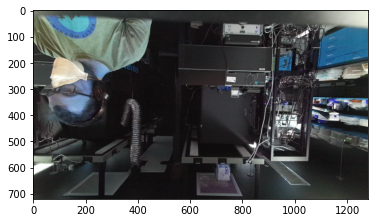

In [28]:
plt.imshow(capture.color[:,:,:3])

In [29]:
capture.color[:,:,:3].shape

(720, 1280, 3)

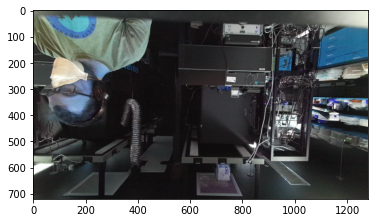

In [20]:
plt.imshow(capture.color)

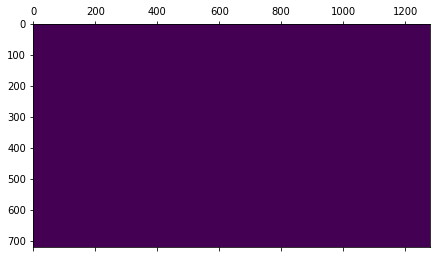

In [25]:
plt.matshow(capture.color[:,:,3])

In [33]:
capture.color.dtype

dtype('uint8')

In [21]:
capture.__dict__

{'_calibration': <pyk4a.calibration.Calibration at 0x7fecc41e3880>,
 '_capture_handle': <capsule object "pyk4a capture handle" at 0x7fecc41e3780>,
 'thread_safe': True,
 '_color_format': <ImageFormat.COLOR_BGRA32: 3>,
 '_color': array([[[149, 149, 131, 255],
         [149, 149, 131, 255],
         [147, 147, 129, 255],
         ...,
         [253, 255, 247, 255],
         [253, 255, 247, 255],
         [252, 255, 246, 255]],
 
        [[147, 148, 128, 255],
         [147, 148, 128, 255],
         [147, 148, 128, 255],
         ...,
         [252, 255, 246, 255],
         [252, 255, 246, 255],
         [252, 255, 246, 255]],
 
        [[145, 145, 127, 255],
         [145, 145, 127, 255],
         [147, 147, 129, 255],
         ...,
         [252, 255, 245, 255],
         [252, 255, 245, 255],
         [253, 255, 246, 255]],
 
        ...,
 
        [[ 71,  68,  63, 255],
         [ 70,  67,  62, 255],
         [ 69,  67,  59, 255],
         ...,
         [ 53,  49,  44, 255],
         [

In [22]:
np.shape(capture.ir)

(576, 640)

In [23]:
capture.depth

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [24]:
capture.ir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

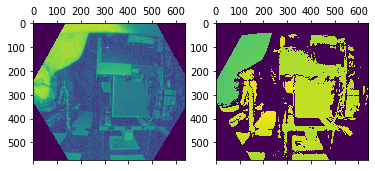

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.matshow(np.log(capture.ir+1))
ax2.matshow(np.log(capture.depth+1))

(array([2.20428e+05, 2.94360e+04, 1.00000e+00, 4.81240e+04, 5.18850e+04,
        7.24600e+03, 4.48300e+03, 5.28500e+03, 1.10000e+03, 6.52000e+02]),
 array([   0.,  593., 1186., 1779., 2372., 2965., 3558., 4151., 4744.,
        5337., 5930.]),
 <BarContainer object of 10 artists>)

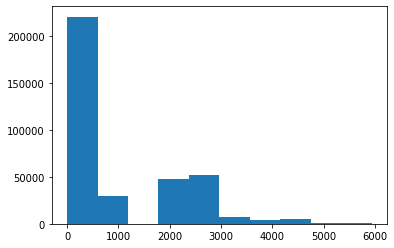

In [26]:
plt.hist(capture.depth.flatten())

In [27]:
depth = capture.depth

In [28]:
depth_pipe = None

In [29]:
from kinectacq.video_io import write_frames  

In [30]:
!ls /home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15

ls: cannot access '/home/tim/Projects/azure_acquisition_template/data/test_recording/2022-02-07_14-24-15': No such file or directory


In [31]:
write_frames(
    filename_prefix / "test.depth.avi",
    depth.astype(np.uint8)[None, :, :],
    codec="ffv1",
    close_pipe=False,
    pipe=depth_pipe,
)

In [32]:
k4a_obj.stop()